In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-dataset/raw_merged_heart_dataset.csv
/kaggle/input/heart-dataset/cleaned_merged_heart_dataset.csv


In [2]:
# 1. Imports and Data Loading
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Read the CSV
df = pd.read_csv('/kaggle/input/heart-dataset/cleaned_merged_heart_dataset.csv')

# 2. Separate features and target
X = df.drop('target', axis=1)
y = df['target']


In [3]:
# 3. Identify numerical vs categorical columns
num_cols = ['age', 'trestbps', 'chol', 'thalachh', 'oldpeak']
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# 4. Build preprocessing pipelines
numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(drop='first', sparse=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

# 5. Create end-to-end pipeline with a classifier
model_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])


In [4]:

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [5]:
# 7. Fit the model
model_pipeline.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalachh', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal'])])),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])

In [6]:
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_proba):.3f}')


              precision    recall  f1-score   support

           0       0.86      0.80      0.83       182
           1       0.83      0.88      0.85       196

    accuracy                           0.84       378
   macro avg       0.84      0.84      0.84       378
weighted avg       0.84      0.84      0.84       378

ROC AUC: 0.886


save explanations

Sample index 0: class=1, prob=0.949


  0%|          | 0/1 [00:00<?, ?it/s]

Saved numeric SHAP values to shap_explanation.json


<Figure size 800x200 with 0 Axes>

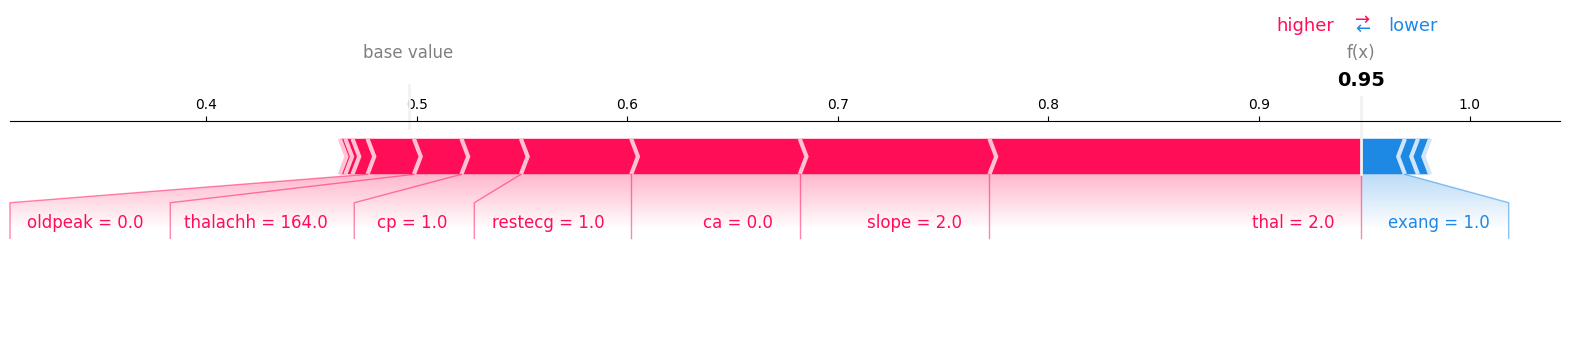

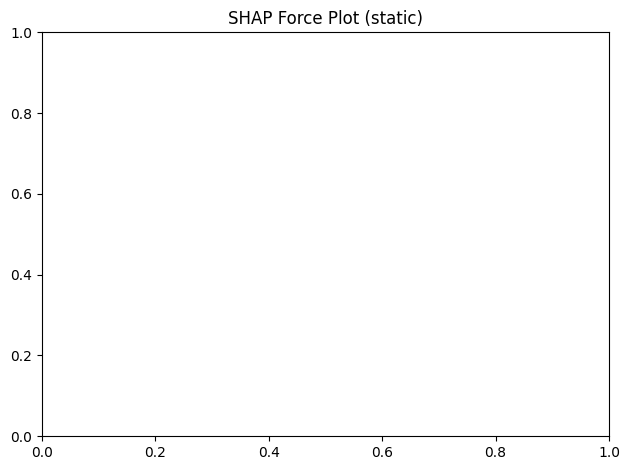

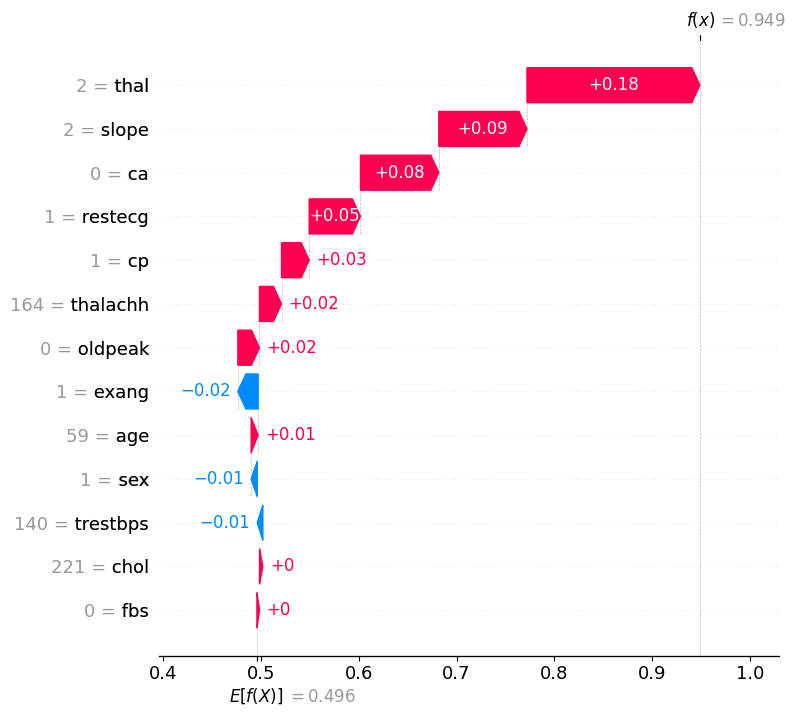

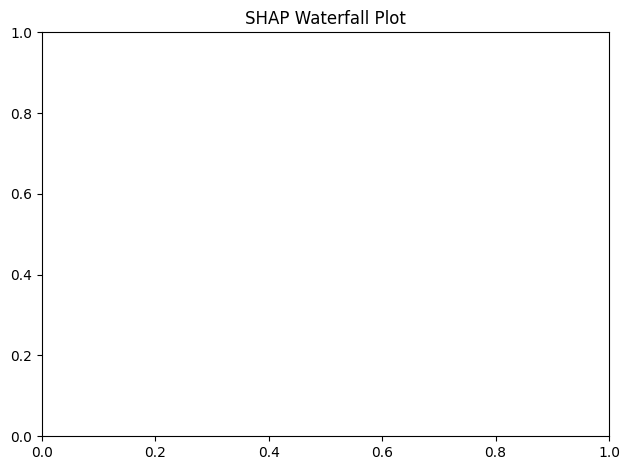

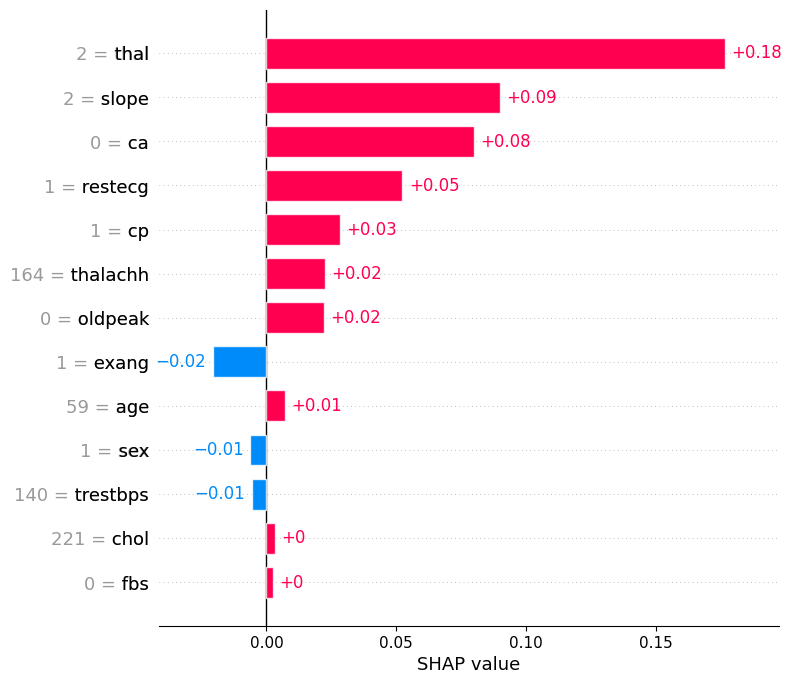

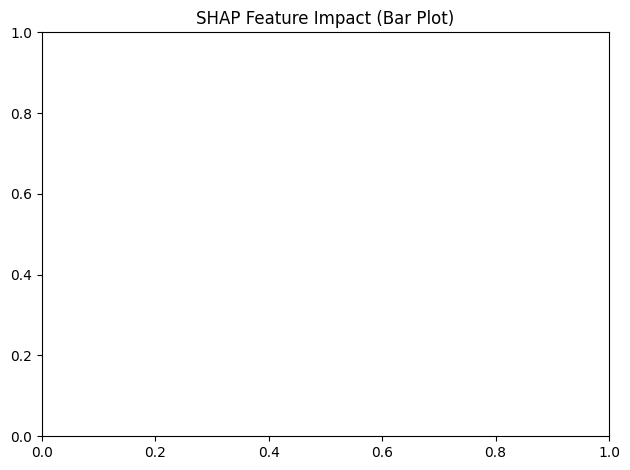

In [9]:
import pandas as pd
import numpy as np
import shap
import json
import matplotlib.pyplot as plt

def f(X_array):
    """
    Takes a 2D numpy array of raw feature values,
    converts to DataFrame and returns positive-class probabilities.
    """
    df = pd.DataFrame(X_array, columns=X_train.columns)
    return model_pipeline.predict_proba(df)[:, 1]

# 2. Choose a small background set
background = shap.sample(X_train, 100, random_state=42)

# 3. Create a KernelExplainer
explainer = shap.KernelExplainer(f, background)

# 4. Pick a test sample
idx = 0
sample = X_test.iloc[[idx]]            # keep as DataFrame
feature_names = sample.columns.tolist()

# 5. Get model prediction
proba = model_pipeline.predict_proba(sample)[0, 1]
pred  = int(model_pipeline.predict(sample)[0])
print(f"Sample index {idx}: class={pred}, prob={proba:.3f}")

# 6. Compute SHAP values (this will be a 1×M array)
shap_values_array = explainer.shap_values(sample, nsamples=200)
shap_vals = shap_values_array[0]       # shape: (n_features,)

# 7. Build a JSON-serializable explanation dict
explanation_dict = {
    "sample_index": idx,
    "predicted_class": pred,
    "predicted_probability": float(proba),
    "base_value": float(explainer.expected_value),
    "shap_values": {
        feat: float(val) for feat, val in zip(feature_names, shap_vals)
    }
}

# 8. Save to JSON file
with open("shap_explanation.json", "w") as f:
    json.dump(explanation_dict, f, indent=2)

print("Saved numeric SHAP values to shap_explanation.json")

# 9. Visualizations

# 9a. Create a SHAP Explanation object for plotting
exp = shap.Explanation(
    values=shap_vals,
    base_values=explainer.expected_value,
    data=sample.iloc[0].values,
    feature_names=feature_names
)

# 9b. Force plot (static, via matplotlib)
plt.figure(figsize=(8, 2))
shap.plots.force(exp, matplotlib=True)
plt.title("SHAP Force Plot (static)")
plt.tight_layout()
plt.show()

# 9c. Waterfall plot
plt.figure(figsize=(6, 4))
shap.plots.waterfall(exp, max_display=len(feature_names))
plt.title("SHAP Waterfall Plot")
plt.tight_layout()
plt.show()

# 9d. Bar plot
plt.figure(figsize=(6, 4))
shap.plots.bar(exp, max_display=len(feature_names))
plt.title("SHAP Feature Impact (Bar Plot)")
plt.tight_layout()
plt.show()

In [8]:
import joblib

# 1. After fitting:
#    model_pipeline.fit(X_train, y_train)

# 2. Save the pipeline to disk
joblib.dump(model_pipeline, "heart_disease_model.joblib")

['heart_disease_model.joblib']

In [13]:
# 1. Install LangChain and the Google-Gemini integration
!pip install --upgrade langchain langchain-google-genai -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 18.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [14]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
import os

# 2. Set your Google AI API key (or export GOOGLE_API_KEY in your shell)
os.environ["GOOGLE_API_KEY"] = ""

In [26]:
# 1. Imports
import json
import time
from pathlib import Path
from langchain_google_genai import ChatGoogleGenerativeAI

# 2. Load explainability JSON
json_path = Path(r"C:\Users\vamsv\Downloads\shap_explanation.json")
exp = json.loads(json_path.read_text(encoding="utf-8"))

# 3. Extract fields
sample_index = exp.get("sample_index")
pred_class = exp.get("predicted_class")
pred_prob = exp.get("predicted_probability")
base_value = exp.get("base_value")
shap_values = exp.get("shap_values", {})

# 4. Feature definitions
feature_defs = {
    "age": "patient’s age (yrs)",
    "chol": "serum cholesterol (mg/dl)",
    "thalachh": "max heart rate achieved",
    "sex": "biological sex (0=female,1=male) if encoded",
    "cp": "chest pain type (encoded)",
    "trestbps": "resting blood pressure (mm Hg)",
    "fbs": "fasting blood sugar >120 mg/dl (binary)",
    "restecg": "resting ECG results (encoded)",
    "exang": "exercise-induced angina (binary)",
    "oldpeak": "ST depression induced by exercise relative to rest",
    "slope": "slope of peak exercise ST segment (encoded)",
    "ca": "number of major vessels colored by fluoroscopy",
    "thal": "thalassemia (encoded)",
}

# 5. Prepare SHAP ranking
sorted_items = sorted(shap_values.items(), key=lambda kv: abs(kv[1]), reverse=True)
def fmt_line(name, value):
    return f"- {name}: {value:+.4f} ({'↑' if value>0 else '↓'} risk)"
all_lines = "\n".join(fmt_line(n, v) for n, v in sorted_items)

# 6. Craft the prompt (merge system guidance to avoid system role issues)
system_instruction = (
    "You are a clinical ML analyst. You are given the meaning of each input feature. "
    "Interpret predictions and their SHAP explainability data. Mention only what "
    "positively contributes to the contribution. Provide the inference in simple English."
)

human_prompt = f"""
{system_instruction}

Patient explainability packet (sample_index={sample_index}):
Prediction:
- predicted_class: {pred_class}
- predicted_probability: {pred_prob:.6f}
- base_value: {base_value:.6f}

SHAP contributions (feature -> signed impact on log-odds/risk proxy):
{all_lines}

Feature definitions (subset):
{chr(10).join(f"- {k}: {v}" for k, v in feature_defs.items())}

Tasks:
- Identify which features drove the risk up (positive SHAP) or down (negative SHAP).
- Explain the clinical meaning of the top 3 drivers.
- State any caveats (encoding, units, correlations, model limitations).
""".strip()

# 7. LangChain Gemini chat setup
# Tip: try switching model if empty responses persist: "gemini-2.0-pro" or "gemini-1.5-pro"
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",
    temperature=0.5,
    max_tokens=1024,
    timeout=60,
    google_api_key="your-key",
    convert_system_message_to_human=True,  # safeguard if system messages are used later
)

# 8. Single human message (avoid system role)
messages = [("human", human_prompt)]

# 9. Invoke with simple retry on empty content
def call_with_retry(messages, attempts=3, delay=2.0):
    last = None
    for i in range(attempts):
        resp = llm.invoke(messages)
        content = getattr(resp, "content", "")
        last = resp
        if isinstance(content, str) and content.strip():
            return resp
        time.sleep(delay * (i + 1))
    return last

response = call_with_retry(messages)

# 10. Print diagnostics if empty
text = getattr(response, "content", "")
print(text if text else "[Empty response from Gemini]")

# Optional: inspect generation info if available
try:
    info = getattr(response, "generation_info", None)
    if info:
        print("\n[Diagnostics] generation_info:\n", info)
except Exception:
    pass


In [ ]:
# Export model and explanation files to the Streamlit app directory
import shutil
import os

# Create target directory if it doesn't exist
os.makedirs('../draft2/models', exist_ok=True)

# Save model to the Streamlit app directory
model_path = "heart_disease_model.joblib"
target_model_path = "../draft2/models/heart_disease_model.joblib"

if os.path.exists(model_path):
    shutil.copy(model_path, target_model_path)
    print(f"Copied model to {target_model_path}")
else:
    print(f"Model file {model_path} does not exist yet. Run the model saving cell first.")

# Save SHAP explanation to the Streamlit app directory
shap_path = "shap_explanation.json"
target_shap_path = "../draft2/models/shap_explanation.json"

if os.path.exists(shap_path):
    shutil.copy(shap_path, target_shap_path)
    print(f"Copied SHAP explanation to {target_shap_path}")
else:
    print(f"SHAP explanation file {shap_path} does not exist yet. Run the SHAP cell first.")